In [6]:
# ====== Offline Throughput Benchmark Result =======
# Backend:                                 engine    
# Successful requests:                     2000      
# Benchmark duration (s):                  94.26     
# Total input tokens:                      626729    
# Total generated tokens:                  388685    
# Last generation throughput (tok/s):      72.93     
# Request throughput (req/s):              21.22     
# Input token throughput (tok/s):          6648.87   
# Output token throughput (tok/s):         4123.50   
# Total token throughput (tok/s):          10772.37  
# ==================================================


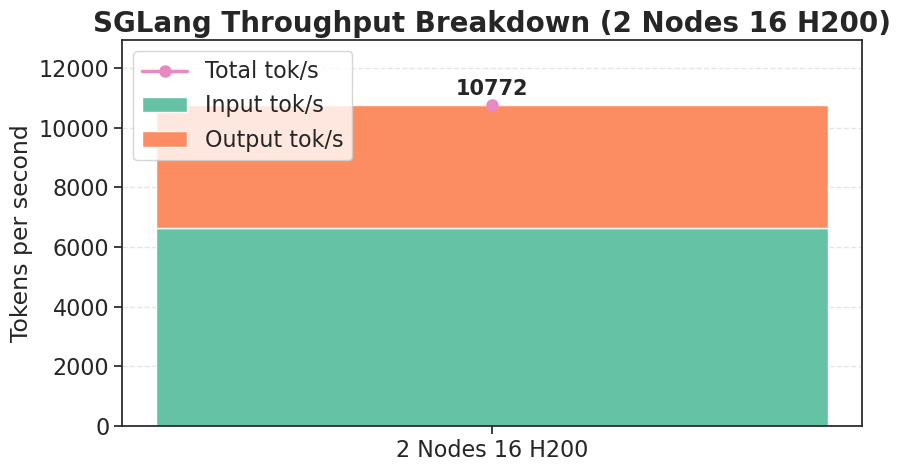

In [12]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# =========================================================
# 全局样式（与你常用的 HPC 图风格保持一致）
# =========================================================
sns.set(style='white', palette='Set2', color_codes=False)
sns.set_style("ticks")

plt.rcParams['font.size'] = 16
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 17
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

colors = sns.color_palette('Set2')  # Set2 调色板
seg_colors = [colors[0], colors[1], colors[2]]  # Input, Output, Total
line_colors = [colors[3], colors[4], colors[5]]  # 备用折线色

# =========================================================
# 数据（可扩展多组配置，如 1机8卡 / 2机16卡）
# =========================================================
data = [
    {"Setting": "2 Nodes 16 H200", "Input tok/s": 6648.87, "Output tok/s": 4123.50, "Total tok/s": 10772.37},
    # {"Setting": "1机8卡", "Input tok/s": 3500, "Output tok/s": 2400, "Total tok/s": 5900},  # 示例
]

df = pd.DataFrame(data)

# =========================================================
# 绘制堆叠条形图
# =========================================================
plt.figure(figsize=(9,5))

# Input 部分
plt.bar(df["Setting"], df["Input tok/s"], color=seg_colors[0], label="Input tok/s")
# Output 部分堆叠在上
plt.bar(df["Setting"], df["Output tok/s"], bottom=df["Input tok/s"], color=seg_colors[1], label="Output tok/s")

# 用黑色折线标出 total
plt.plot(df["Setting"], df["Total tok/s"], marker="o", markersize=8, linewidth=2.5, color=line_colors[0], label="Total tok/s")

# 文字标注 total 值
for i, val in enumerate(df["Total tok/s"]):
    plt.text(i, val + 200, f"{val:.0f}", ha="center", va="bottom", fontsize=15, fontweight="bold")

plt.title("SGLang Throughput Breakdown (2 Nodes 16 H200)", fontweight="bold")
plt.ylabel("Tokens per second")
# ylim
plt.ylim(0, max(df["Total tok/s"]) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(loc="upper left")
plt.tight_layout()

plt.savefig("sglang_throughput_breakdown.png", dpi=220, bbox_inches="tight")
plt.show()


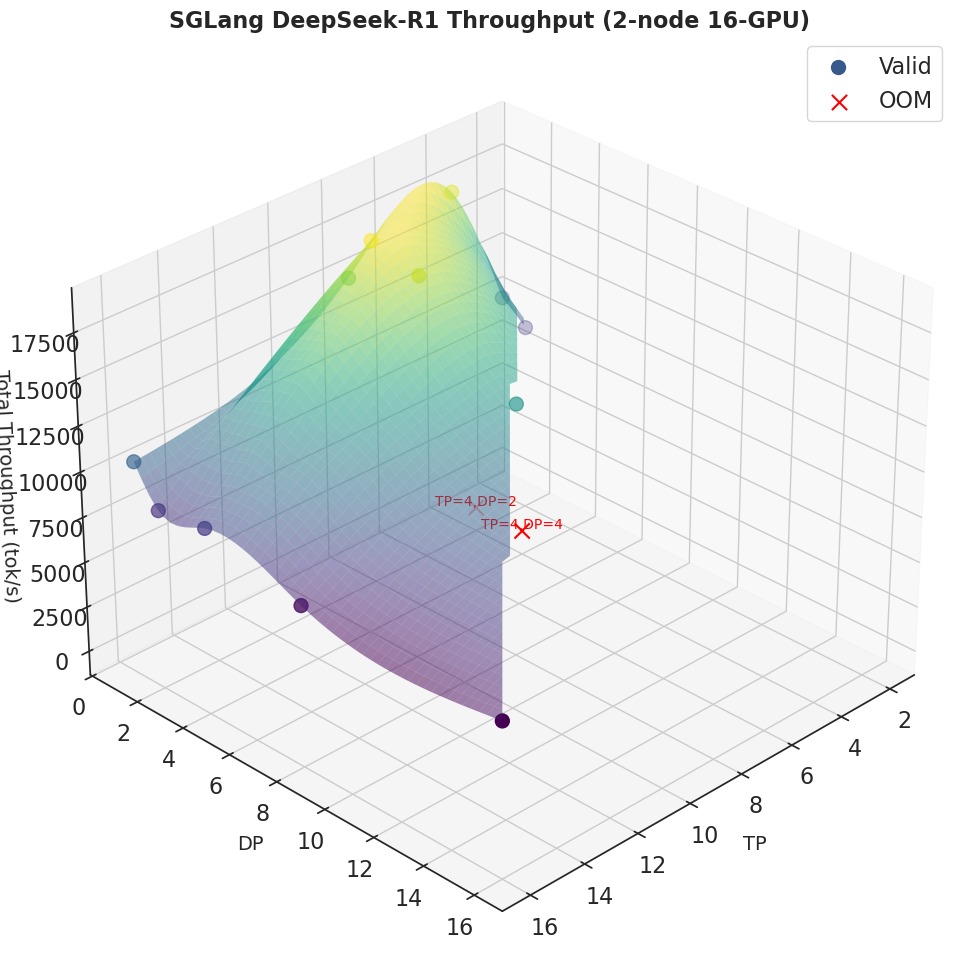

In [35]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# 数据
experiments = [
    {"TP": 2,  "DP": 1,  "total": 10121.05},
    {"TP": 2,  "DP": 2,  "total": 9039.90},
    {"TP": 4,  "DP": 1,  "total": 17324.45},
    {"TP": 4,  "DP": 2,  "total": None},  # OOM
    {"TP": 4,  "DP": 4,  "total": None},  # OOM
    {"TP": 8,  "DP": 1,  "total": 15159.39},
    {"TP": 8,  "DP": 2,  "total": 17805.00},
    {"TP": 8,  "DP": 4,  "total": 17111.97},
    {"TP": 8,  "DP": 8,  "total": 12679.88},
    {"TP": 16, "DP": 1,  "total": 10567.17},
    {"TP": 16, "DP": 2,  "total": 8566.00},
    {"TP": 16, "DP": 4,  "total": 8959.44},
    {"TP": 16, "DP": 8,  "total": 7557.84},
    {"TP": 16, "DP": 16, "total": 7202.73},
]

# 提取坐标
TP = np.array([e["TP"] for e in experiments if e["total"] is not None])
DP = np.array([e["DP"] for e in experiments if e["total"] is not None])
throughput = np.array([e["total"] for e in experiments if e["total"] is not None])

# OOM点
TP_oom = np.array([e["TP"] for e in experiments if e["total"] is None])
DP_oom = np.array([e["DP"] for e in experiments if e["total"] is None])

# 绘制
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# 散点图
sc = ax.scatter(TP, DP, throughput, c=throughput, cmap='viridis', s=100, label='Valid')
ax.scatter(TP_oom, DP_oom, np.zeros_like(TP_oom), c='red', marker='x', s=120, label='OOM')


# 为OOM点加文字标注
for tp, dp in zip(TP_oom, DP_oom):
    ax.text(tp, dp, 0, f"TP={tp},DP={dp}", color='red', fontsize=10, ha='center', va='bottom')


# 曲面拟合
from scipy.interpolate import griddata

TP_grid, DP_grid = np.meshgrid(np.linspace(min(TP), max(TP), 50),
                               np.linspace(min(DP), max(DP), 50))
Z_grid = griddata((TP, DP), throughput, (TP_grid, DP_grid), method='cubic')

ax.plot_surface(TP_grid, DP_grid, Z_grid, cmap='viridis', alpha=0.5, edgecolor='none')

# 标签
ax.set_xlabel("TP", fontsize=14, labelpad=10)
ax.set_ylabel("DP", fontsize=14, labelpad=10)
ax.set_zlabel("Total Throughput (tok/s)", fontsize=14, labelpad=10)
ax.set_title("SGLang DeepSeek-R1 Throughput (2-node 16-GPU)", fontsize=16, fontweight='bold')
ax.legend()


# 改变视角角度
# ax.view_init(elev=35, azim=20)
ax.view_init(30, 45)    # 从左前上方看
plt.tight_layout()
plt.show()


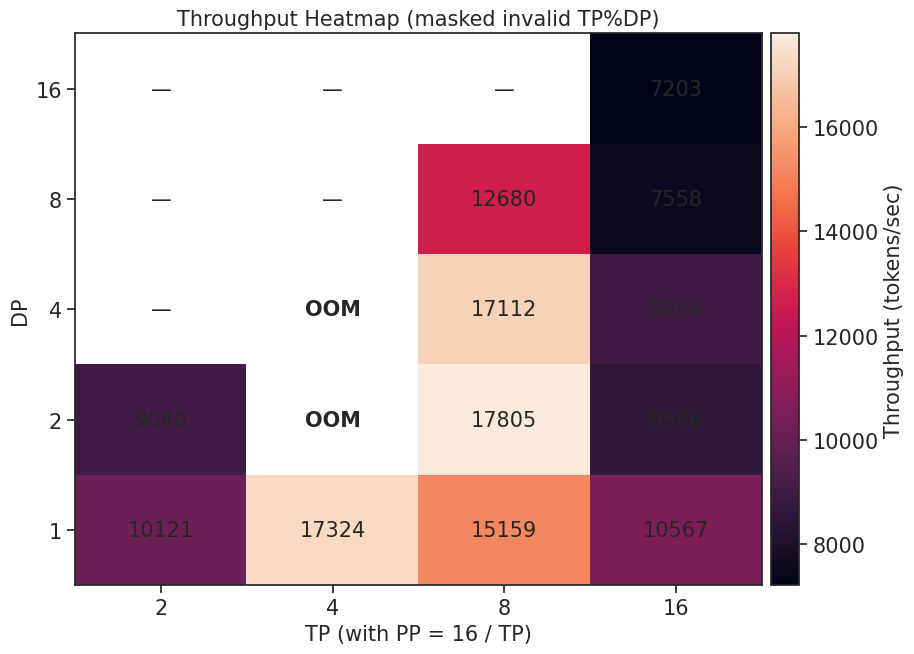

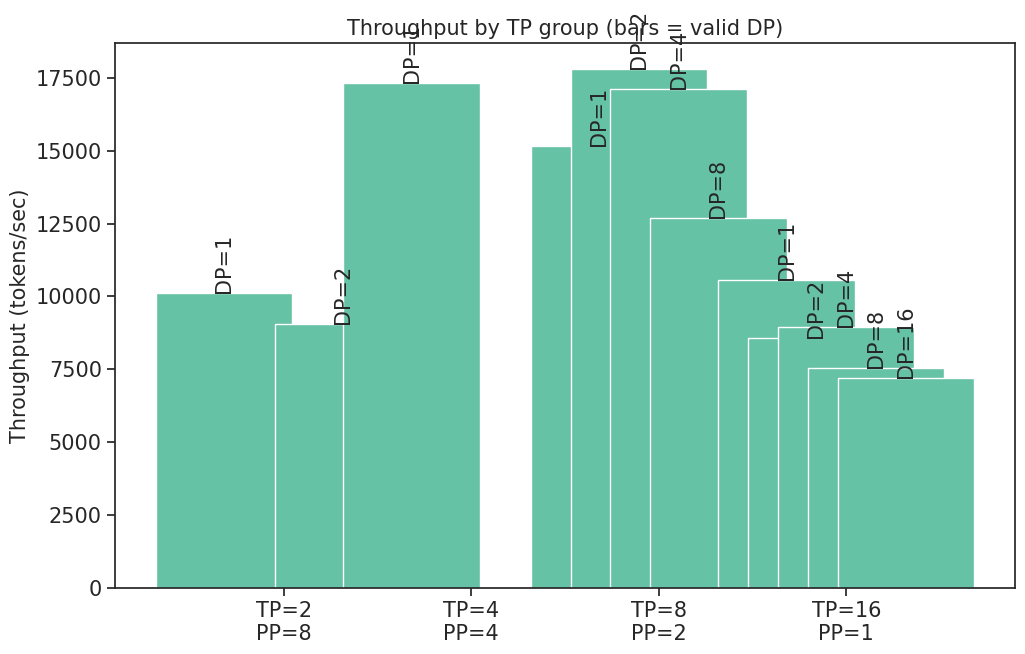

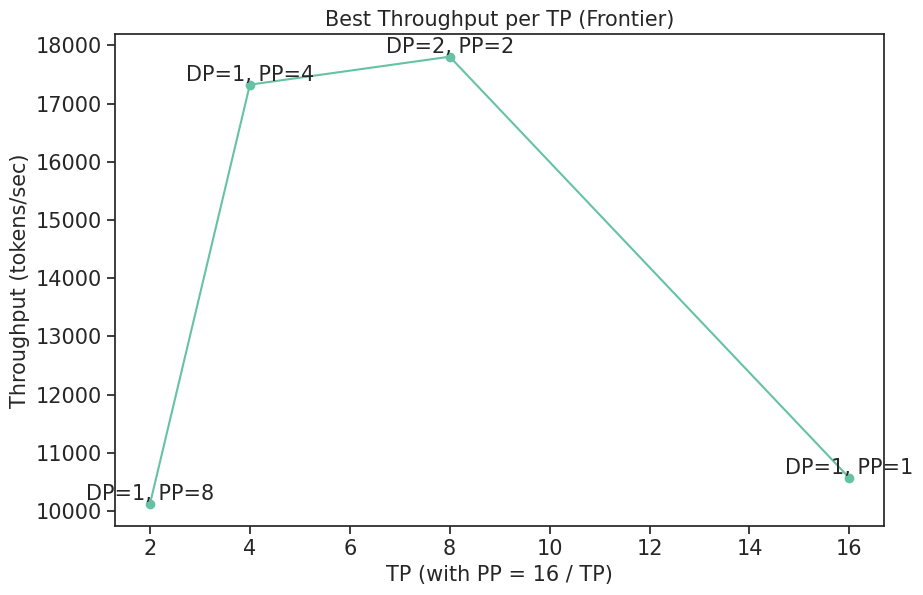

In [37]:
# Re-run the plotting code (previous session reset).

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 15
plt.rcParams["axes.titlesize"] = 15
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["legend.fontsize"] = 15
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15

# -------------------- data --------------------
experiments = [
    {"TP": 2,  "DP": 1,  "input": 6246.87, "output": 3874.18, "total": 10121.05},
    {"TP": 2,  "DP": 2,  "input": 5579.57, "output": 3460.34, "total": 9039.90},
    {"TP": 4,  "DP": 1,  "input": 10692.91, "output": 6631.53, "total": 17324.45},
    # TP=4, DP=2/4 OOM
    {"TP": 8,  "DP": 1,  "input": 9356.61,  "output": 5802.78, "total": 15159.39},
    {"TP": 8,  "DP": 2,  "input": 10989.52, "output": 6815.48, "total": 17805.00},
    {"TP": 8,  "DP": 4,  "input": 10561.77, "output": 6550.20, "total": 17111.97},
    {"TP": 8,  "DP": 8,  "input": 7826.21,  "output": 4853.66, "total": 12679.88},
    {"TP": 16, "DP": 1,  "input": 6522.22,  "output": 4044.95, "total": 10567.17},
    {"TP": 16, "DP": 2,  "input": 5287.06,  "output": 3278.93, "total": 8566.00},
    {"TP": 16, "DP": 4,  "input": 5529.90,  "output": 3429.54, "total": 8959.44},
    {"TP": 16, "DP": 8,  "input": 4664.81,  "output": 2893.02, "total": 7557.84},
    {"TP": 16, "DP": 16, "input": 4445.64,  "output": 2757.10, "total": 7202.73},
]

df = pd.DataFrame(experiments)
oom_list = {(4,2), (4,4)}

# -------------------- 1) Masked heatmap --------------------
tps = sorted(df["TP"].unique())
dps = sorted(df["DP"].unique())
grid = np.full((len(dps), len(tps)), np.nan)

for i, dp in enumerate(dps):
    for j, tp in enumerate(tps):
        if tp % dp != 0:
            continue  # invalid by constraint -> NaN
        row = df[(df["TP"] == tp) & (df["DP"] == dp)]
        if not row.empty:
            grid[i, j] = row["total"].values[0]

masked = np.ma.masked_invalid(grid)

fig1 = plt.figure(figsize=(9.5, 6.8))
ax1 = fig1.add_subplot(111)
im = ax1.imshow(masked, origin="lower", aspect="auto")

ax1.set_xticks(range(len(tps)))
ax1.set_xticklabels([str(tp) for tp in tps])
ax1.set_yticks(range(len(dps)))
ax1.set_yticklabels([str(dp) for dp in dps])
ax1.set_xlabel("TP (with PP = 16 / TP)")
ax1.set_ylabel("DP")
ax1.set_title("Throughput Heatmap (masked invalid TP%DP)")

for i, dp in enumerate(dps):
    for j, tp in enumerate(tps):
        if (tp % dp) != 0:
            ax1.text(j, i, "—", ha="center", va="center")
            continue
        if (tp, dp) in oom_list:
            ax1.text(j, i, "OOM", ha="center", va="center", fontweight="bold")
        elif not np.isnan(grid[i, j]):
            ax1.text(j, i, f"{grid[i, j]:.0f}", ha="center", va="center")

cb = fig1.colorbar(im, ax=ax1, pad=0.012)
cb.set_label("Throughput (tokens/sec)")

# heatmap_png = "/mnt/data/sglang_heatmap_throughput.png"
# heatmap_pdf = "/mnt/data/sglang_heatmap_throughput.pdf"
plt.tight_layout()
# fig1.savefig(heatmap_png, bbox_inches="tight", dpi=220)
# fig1.savefig(heatmap_pdf, bbox_inches="tight")

# -------------------- 2) Grouped bars per TP --------------------
fig2 = plt.figure(figsize=(10.5, 6.8))
ax2 = fig2.add_subplot(111)

group_width = 0.7
gap = 0.4
x_positions = []
heights = []
labels = []
tick_positions = []
tick_labels = []

x = 0.0
for tp in tps:
    vals = []
    dplist = []
    for dp in dps:
        if tp % dp == 0:
            row = df[(df["TP"] == tp) & (df["DP"] == dp)]
            if not row.empty:
                vals.append(row["total"].values[0])
                dplist.append(dp)
    k = len(dplist)
    if k == 0:
        continue
    offsets = np.linspace(-group_width/2, group_width/2, k)
    for idx, dp in enumerate(dplist):
        x_positions.append(x + offsets[idx])
        heights.append(vals[idx])
        labels.append(f"DP={dp}")
        if (tp, dp) in oom_list:
            ax2.text(x + offsets[idx], vals[idx], "OOM", rotation=90, ha="center", va="bottom")
    tick_positions.append(x)
    tick_labels.append(f"TP={tp}\nPP={16//tp}")
    x += group_width + gap

bars = ax2.bar(x_positions, heights)
ax2.set_xticks(tick_positions)
ax2.set_xticklabels(tick_labels)
ax2.set_ylabel("Throughput (tokens/sec)")
ax2.set_title("Throughput by TP group (bars = valid DP)")

for (xp, h, lbl) in zip(x_positions, heights, labels):
    ax2.text(xp, h, lbl, ha="center", va="bottom", rotation=90)

# grouped_png = "/mnt/data/sglang_grouped_bars_throughput.png"
# grouped_pdf = "/mnt/data/sglang_grouped_bars_throughput.pdf"
plt.tight_layout()
# fig2.savefig(grouped_png, bbox_inches="tight", dpi=220)
# fig2.savefig(grouped_pdf, bbox_inches="tight")

# -------------------- 3) Frontier line: best DP per TP --------------------
fig3 = plt.figure(figsize=(9.5, 6.2))
ax3 = fig3.add_subplot(111)

best_tp = []
best_thr = []
best_labels = []
for tp in tps:
    sub = df[df["TP"] == tp]
    if sub.empty:
        continue
    row = sub.loc[sub["total"].idxmax()]
    best_tp.append(tp)
    best_thr.append(row["total"])
    best_labels.append(f"DP={int(row['DP'])}, PP={16//tp}")

ax3.plot(best_tp, best_thr, marker="o")
for t, z, txt in zip(best_tp, best_thr, best_labels):
    ax3.text(t, z, txt, ha="center", va="bottom")

ax3.set_xlabel("TP (with PP = 16 / TP)")
ax3.set_ylabel("Throughput (tokens/sec)")
ax3.set_title("Best Throughput per TP (Frontier)")

# frontier_png = "/mnt/data/sglang_frontier_best_per_tp.png"
# frontier_pdf = "/mnt/data/sglang_frontier_best_per_tp.pdf"
plt.tight_layout()
# fig3.savefig(frontier_png, bbox_inches="tight", dpi=220)
# fig3.savefig(frontier_pdf, bbox_inches="tight")

# heatmap_png, grouped_png, frontier_png
